In [ ]:
import datetime

date = datetime.datetime.now()
print(f'Today is Happy{date: %A, %d, %m, %Y}.', '\n')

import os
from glob import glob
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import scipy.stats as sp
import torch

sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12})   
sns.set_style('whitegrid', rc={'font.family': 'serif', 'font.serif': 'Times New Roman'})

### Button

In [163]:
windows = True # True for Windows, False for MAC
stim_type = 'elec' # 'opt' or 'elec'
top1 = False # True for top1, False if top2
class_num = 16

if windows:
    base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\ArtificialVision'
    slash = '\\'
else:
    base_dir = '/Users/naminan/Development/ArtificialVision'
    slash = '/'

data_dir = os.path.join(base_dir, 'data')
data_path = os.path.join(data_dir, '210827_ANNA_Removing_uncontaminated_data.csv')
label_path = os.path.join(data_dir, '211105_QAs_for_Set0_CNN_SVC_4classes_partial.csv')
pred_dir =  os.path.join(os.path.join(data_dir, 'Human_Expert'), '211202')
quesdata_files = glob(f'{base_dir}{slash}data{slash}Question_Banks_AI_Hub_final{slash}16classes{slash}set0{slash}*')
fig_path = glob(f'{base_dir}\\figures')[0]

df = pd.read_csv(data_path)
l = list(range(df.shape[0]))
random.seed(22)
set_1 = random.sample(l, class_num)
sets = [set_1]
face_lst = [df.iloc[i, 0] for i in set_1]
age_lst = [df.iloc[i, 1].split('대')[0] for i in set_1]
gen_lst = [df.iloc[i, 2] for i in set_1]
gen_dic = {'남':'M', '여':'F'}
face_att_dic = {face_lst[i] : [age_lst[i], gen_dic[gen_lst[i]]] for i in range(len(face_lst))}
image_dir = f'{data_dir}{slash}sample_for_dev_{stim_type}'

Human data

In [164]:
if stim_type == 'opt':
  sel_ppl = list(range(300, 309)) + list(range(400, 408)) + [611] # 18 subjects
elif stim_type == 'elec': 
  sel_ppl = [499, 500] + list(range(502, 509)) + list(range(601, 607)) + list(range(608, 611)) # 18 subjects
random.seed(42)
sel_ppl = random.sample(sel_ppl, len(sel_ppl)//2)

human_df = pd.DataFrame()
preds = []
n = 9
for i in range(1, 80*n+1, 80):
    j = i+79 
    temp_df = pd.read_csv(os.path.join(pred_dir, f'main_test({i}_{j}).csv'))
    temp_df = temp_df[temp_df['유저식별아이디'].isin(sel_ppl)]
    human_df = pd.concat([human_df, temp_df], axis=1)
    # To calculate the mode
    if top1:
      temp_df = temp_df.loc[:, temp_df.columns.str.startswith('선택_A')]
      temp_df = temp_df.fillna(0)
      for k in range(len(temp_df.columns)):
          temp_preds = temp_df.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds = temp_preds[temp_preds > 0]
          temp_pred = np.bincount(temp_preds).argmax() 
          preds.append(temp_pred)
    else:
      temp_df1 = temp_df.loc[:, temp_df.columns.str.startswith('선택_A')]
      temp_df2 = temp_df.loc[:, temp_df.columns.str.startswith('선택_B')]
      temp_df1, temp_df2 = temp_df1.fillna(0), temp_df2.fillna(0)
      for k in range(len(temp_df1.columns)):
          temp_preds1 = temp_df1.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds2 = temp_df2.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds = np.concatenate([temp_preds1, temp_preds2])
          temp_preds = temp_preds[temp_preds > 0]
          temp_pred = np.bincount(temp_preds).argmax() 
          preds.append(temp_pred)  
        
orig_human_df = human_df
human_df = human_df.fillna(0)

sel_col = []
for j in range(1, 80*n+1):
  if top1:
    temp_str = f'선택_A_{j}'
    sel_col.append(temp_str)
  else:
    temp_str1 = f'선택_A_{j}'
    temp_str2 = f'선택_B_{j}'
    sel_col.append(temp_str1)
    sel_col.append(temp_str2)

human_df = human_df[sel_col]
human_df.index = sel_ppl 

if top1:
  human_df.columns = list(range(80*n))
else:
  human_df.columns = list(range(2*80*n))

question_df = pd.read_csv(label_path)

if top1:
  human_df.columns = question_df['Answer']
else:
  human_df.columns = [ans for ans in question_df['Answer'] for _ in (0, 1)]

processed_human_df = human_df.copy()
for (j, ans_file) in enumerate(processed_human_df.columns):
    face, pix, gs, par = ans_file.split('.')[0].split('_')
    act_face = int(face)
    for i in range(processed_human_df.shape[0]):
        pred_face = int(processed_human_df.iloc[i, j])
        if act_face == pred_face:
            processed_human_df.iloc[i, j] = 1.0
        else:
            processed_human_df.iloc[i, j] = 0.0

if not top1:
  processed_human_df = processed_human_df.iloc[:, 0:1440:2] + processed_human_df.iloc[:, 1:1440:2]

processed_human_df_T = processed_human_df.transpose()
face_lst, hyp_lst, pix_lst, gs_lst, par_lst, ang_lst, exp_lst, age_lst, gen_lst = [], [], [], [], [], [], [], [], []
for (i, ans_file) in enumerate(processed_human_df_T.index):
  face, pix, gs, par = ans_file.split('.')[0].split('_')
  face_lst.append(face)
  hyp_lst.append(f'{pix}_{gs}')
  pix_lst.append(pix)
  gs_lst.append(gs)
  par_lst.append(par)
  ang_lst.append(par.split('C')[-1])
  exp_lst.append(par.split('C')[0].split('E')[-1])
  age_lst.append(face_att_dic[int(face)][0])
  gen_lst.append(face_att_dic[int(face)][1])
processed_human_df_T['Face'] = face_lst
processed_human_df_T['Hyp'] = hyp_lst
processed_human_df_T['PIX'] = pix_lst
processed_human_df_T['GS'] = gs_lst
processed_human_df_T['Par'] = par_lst
processed_human_df_T['Ang'] = ang_lst
processed_human_df_T['Exp'] = exp_lst
processed_human_df_T['Age'] = age_lst
processed_human_df_T['Gen'] = gen_lst
processed_human_df_T['HumMean'] = processed_human_df_T[sel_ppl].mean(axis=1)
processed_human_df_T['HumMode'] = preds
temp_lst = list(map(int, (processed_human_df_T['HumMode'].astype(int) == processed_human_df_T['Face'].astype(int)).tolist()))
processed_human_df_T['HumMode'] = temp_lst


setorder_lst = [n for n in range(9)]*80
setorder_lst.sort()
processed_human_df_T['Set'] = setorder_lst

processed_human_df_T = processed_human_df_T.reset_index()
processed_human_df_T['Set'] = [idx//80+1 for idx in processed_human_df_T.index]
processed_human_df_T.index = processed_human_df_T['index']

processed_human_df_T

,index,503,499,508,610,606,502,603,500,608,...,PIX,GS,Par,Ang,Exp,Age,Gen,HumMean,HumMode,Set
index,,,,,,,,,,,,,,,,,,,,,
19070311_16PIX_8GS_S001L1E03C7.jpg,19070311_16PIX_8GS_S001L1E03C7.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,16PIX,8GS,S001L1E03C7,7,03,50,M,0.222222,1,1
19080133_32PIX_4GS_S001L1E03C7.jpg,19080133_32PIX_4GS_S001L1E03C7.jpg,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,32PIX,4GS,S001L1E03C7,7,03,30,F,0.666667,1,1
19090222_32PIX_8GS_S001L1E01C4.jpg,19090222_32PIX_8GS_S001L1E01C4.jpg,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,32PIX,8GS,S001L1E01C4,4,01,50,F,0.777778,1,1
19090631_16PIX_2GS_S001L1E03C7.jpg,19090631_16PIX_2GS_S001L1E03C7.jpg,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,16PIX,2GS,S001L1E03C7,7,03,40,M,0.555556,1,1
19072221_32PIX_2GS_S001L1E01C4.jpg,19072221_32PIX_2GS_S001L1E01C4.jpg,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,32PIX,2GS,S001L1E01C4,4,01,40,F,0.666667,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19072221_16PIX_8GS_S001L1E01C7.jpg,19072221_16PIX_8GS_S001L1E01C7.jpg,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,16PIX,8GS,S001L1E01C7,7,01,40,F,0.777778,1,9
19082131_16PIX_2GS_S001L1E01C7.jpg,19082131_16PIX_2GS_S001L1E01C7.jpg,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,16PIX,2GS,S001L1E01C7,7,01,30,M,0.333333,0,9
19092521_32PIX_4GS_S001L1E01C7.jpg,19092521_32PIX_4GS_S001L1E01C7.jpg,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,32PIX,4GS,S001L1E01C7,7,01,50,F,0.888889,1,9


Model data

In [165]:
model_type1_list = [''] # ['PCA', 'PCA', '', '']
model_type2_list = ['CNN_SVC'] # ['SVC', 'LR', 'CNN_LR', 'CNN_SVC']
seed_list = [22, 77, 2, 100, 81, 42, 7, 1, 55, 50] 
pix_order_list = ['16PIX', '24PIX', '32PIX', '64PIX', '128PIX']
gs_order_list = ['2GS', '4GS', '6GS', '8GS', '16GS']

for (model_type1, model_type2) in zip(model_type1_list, model_type2_list): 
    model_type = model_type1 + model_type2
    input_folder = [df.iloc[i, 0] for i in sets[0]] 
    assert len(input_folder) == 16
    com_obj = itertools.combinations(input_folder, 16)
    com_list = list(com_obj)

    mac_df = pd.DataFrame()
    for i in range(len(quesdata_files)):
        quesdata_path = quesdata_files[i]
        seed = int(os.path.basename(quesdata_path).split('d')[-1])

        for n in range(len(os.listdir(quesdata_path))):
            print(seed, n)

            preprocessed_data_path =  os.path.join(quesdata_path, f'comb{n}') 
            high_analysis_path = os.path.join(preprocessed_data_path, f'High_Analysis_{stim_type}')
            
            add_high_df = pd.read_csv(os.path.join(high_analysis_path, f'High_Level_Data_Analysis_{model_type1}_{model_type2}.csv'))
            add_high_df['Hit Rate'] = add_high_df['correctness'].replace(['correct', 'wrong'], [1, 0]) 
            add_high_df = add_high_df[['file_name', 'actual_person', 'Hit Rate']]
            add_high_df['actual_person'] = add_high_df['actual_person'].astype(int)
            
            img_list, hyperpar_list, par_list = [], [], []
            for i in range(add_high_df.shape[0]):
                file_name = add_high_df['file_name'][i].split('.')[0]
                pix, gs, par = file_name.split('_')
                per = add_high_df['actual_person'][i]
                img = str(per) + '_' + str(pix) + '_' + str(gs) + '_' + str(par) + '.jpg'
                img_list.append(img)
                hyperpar_list.append(str(pix) + '_' + str(gs))
                par_list.append(str(par))
            add_high_df['img'] = img_list
            add_high_df['hyperpar'] = hyperpar_list
            add_high_df['par'] = par_list
            
            add_high_df = add_high_df[['img', 'hyperpar', 'par', 'Hit Rate']]
        
        add_high_df['Seed'] = [seed] * add_high_df.shape[0]
        
        mac_df = pd.concat([mac_df, add_high_df], axis=0)

new_hyperpar_name_list = ['16PIX_2GS', '16PIX_4GS', '16PIX_8GS', 
                          '32PIX_2GS', '32PIX_4GS', '32PIX_8GS',  
                          '64PIX_2GS', '64PIX_4GS', '64PIX_8GS']
par_list = ['S001L1E01C4', 'S001L1E01C7', 'S001L1E01C10',
            'S001L1E02C7',
            'S001L1E03C7']
mac_df = mac_df[mac_df['hyperpar'].isin(new_hyperpar_name_list)]
mac_df = mac_df[mac_df['par'].isin(par_list)]

mac_df = mac_df.pivot(index='Seed', columns='img', values='Hit Rate')
mac_df_T = mac_df.T
mac_df_T['ModMean'] = mac_df_T[seed_list].mean(axis=1)

mac_df_T

1 0
100 0
2 0
22 0
42 0
50 0
55 0
7 0
77 0
81 0


Seed,1,2,7,22,42,50,55,77,81,100,ModMean
img,,,,,,,,,,,
19070231_16PIX_2GS_S001L1E01C10.jpg,0,1,1,0,0,0,1,0,1,1,0.5
19070231_16PIX_2GS_S001L1E01C4.jpg,0,0,0,0,0,0,0,0,0,0,0.0
19070231_16PIX_2GS_S001L1E01C7.jpg,0,1,0,0,1,0,1,0,0,1,0.4
19070231_16PIX_2GS_S001L1E02C7.jpg,0,0,0,0,1,0,0,0,0,0,0.1
19070231_16PIX_2GS_S001L1E03C7.jpg,0,1,1,0,1,0,0,1,1,0,0.5
...,...,...,...,...,...,...,...,...,...,...,...
19092711_64PIX_8GS_S001L1E01C10.jpg,1,1,1,1,1,1,1,1,1,1,1.0
19092711_64PIX_8GS_S001L1E01C4.jpg,1,1,1,1,1,1,1,1,1,1,1.0
19092711_64PIX_8GS_S001L1E01C7.jpg,1,1,1,1,1,1,1,1,1,1,1.0


Merged data

In [166]:
mer_df = pd.merge(processed_human_df_T, mac_df_T, left_index=True, right_index=True)
mer_df = mer_df[['HumMean', 'ModMean', 'Hyp', 'Ang', 'Exp', 'Age', 'Gen']]

hum_df = mer_df[['HumMean', 'Hyp', 'Ang', 'Exp', 'Age', 'Gen']]
mod_df = mer_df[['ModMean', 'Hyp', 'Ang', 'Exp', 'Age', 'Gen']]

hum_df['HvsM'] = ['Hum'] * hum_df.shape[0]
mod_df['HvsM'] = ['Mod'] * mod_df.shape[0]

hum_df.columns = ['Mean', 'Hyp', 'Ang', 'Exp', 'Age', 'Gen', 'HvsM']
mod_df.columns = ['Mean', 'Hyp', 'Ang', 'Exp', 'Age', 'Gen', 'HvsM']

mer_df = pd.concat([hum_df, mod_df], axis=0)

mer_df

,Mean,Hyp,Ang,Exp,Age,Gen,HvsM
19070311_16PIX_8GS_S001L1E03C7.jpg,0.222222,16PIX_8GS,7,03,50,M,Hum
19080133_32PIX_4GS_S001L1E03C7.jpg,0.666667,32PIX_4GS,7,03,30,F,Hum
19090222_32PIX_8GS_S001L1E01C4.jpg,0.777778,32PIX_8GS,4,01,50,F,Hum
19090631_16PIX_2GS_S001L1E03C7.jpg,0.555556,16PIX_2GS,7,03,40,M,Hum
19072221_32PIX_2GS_S001L1E01C4.jpg,0.666667,32PIX_2GS,4,01,40,F,Hum
...,...,...,...,...,...,...,...
19072221_16PIX_8GS_S001L1E01C7.jpg,0.100000,16PIX_8GS,7,01,40,F,Mod
19082131_16PIX_2GS_S001L1E01C7.jpg,0.000000,16PIX_2GS,7,01,30,M,Mod
19092521_32PIX_4GS_S001L1E01C7.jpg,0.700000,32PIX_4GS,7,01,50,F,Mod
19081632_64PIX_2GS_S001L1E01C7.jpg,1.000000,64PIX_2GS,7,01,30,M,Mod


In [167]:
mer_df.to_csv((os.path.join(fig_path, f'faceConAgeGen_{stim_type}.csv')))

Results

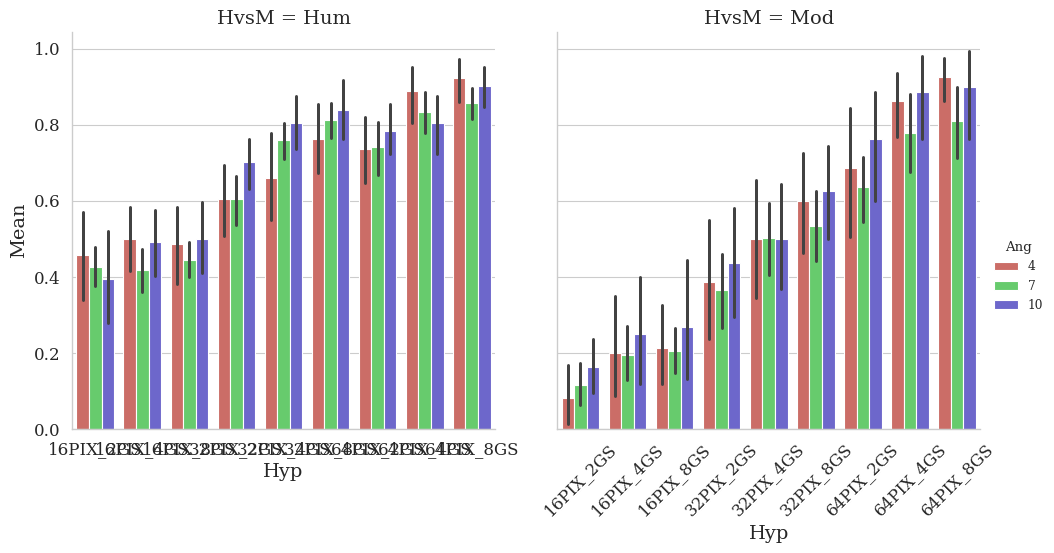

In [168]:
# Is there a visual angle effect?

order = ['16PIX_2GS', '16PIX_4GS', '16PIX_8GS',
         '32PIX_2GS', '32PIX_4GS', '32PIX_8GS',
         '64PIX_2GS', '64PIX_4GS', '64PIX_8GS']
hue_order = ['4', '7','10']
sns.catplot(x='Hyp', y='Mean', col='HvsM', hue='Ang', data=mer_df,
            palette=sns.color_palette("hls", len(hue_order)),
            order=order, hue_order=hue_order,
            kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Facial Recognition Accuracy')
plt.show()

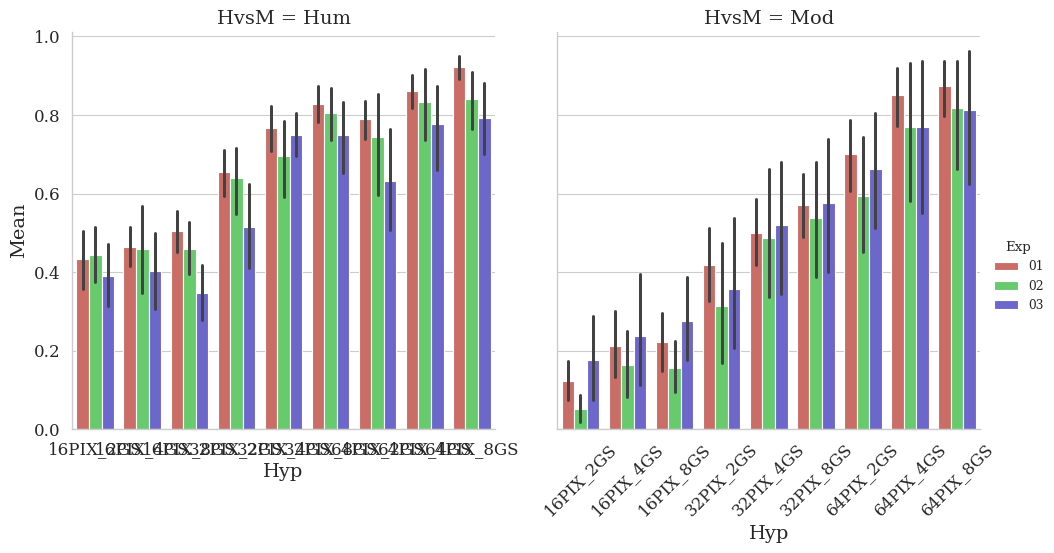

In [169]:
# Is there a facial expression effect?

order = ['16PIX_2GS', '16PIX_4GS', '16PIX_8GS',
         '32PIX_2GS', '32PIX_4GS', '32PIX_8GS',
         '64PIX_2GS', '64PIX_4GS', '64PIX_8GS']
hue_order = ['01', '02', '03']
sns.catplot(x='Hyp', y='Mean', col='HvsM', hue='Exp', data=mer_df,
            palette=sns.color_palette("hls", len(hue_order)),
            order=order, hue_order=hue_order,
            kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Facial Recognition Accuracy')
plt.show()

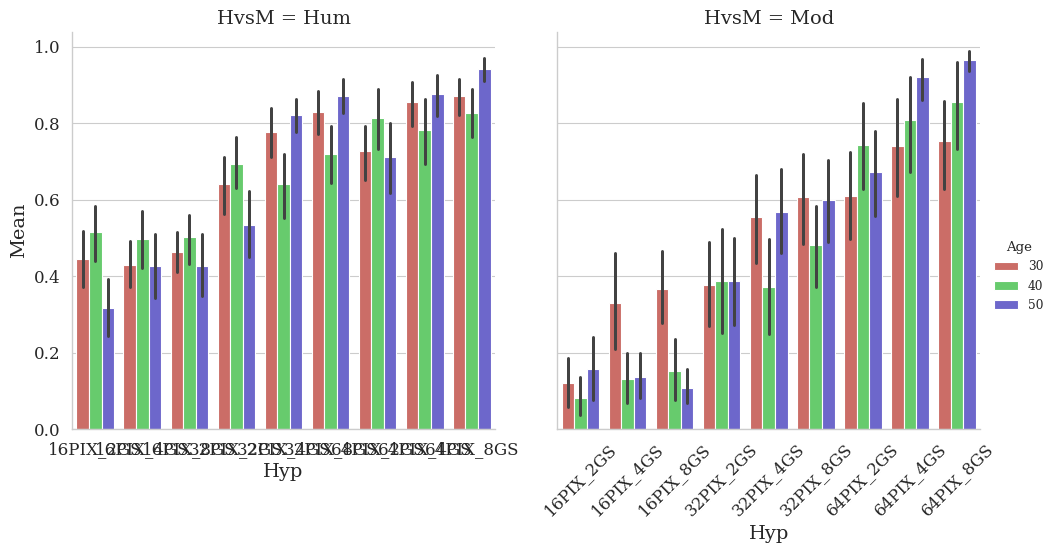

In [170]:
# Is there an age effect?

order = ['16PIX_2GS', '16PIX_4GS', '16PIX_8GS',
         '32PIX_2GS', '32PIX_4GS', '32PIX_8GS',
         '64PIX_2GS', '64PIX_4GS', '64PIX_8GS']
hue_order = ['30', '40', '50']
sns.catplot(x='Hyp', y='Mean', col='HvsM', hue='Age', data=mer_df,
            palette=sns.color_palette("hls", len(hue_order)),
            order=order, hue_order=hue_order,
            kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Facial Recognition Accuracy')
plt.show()

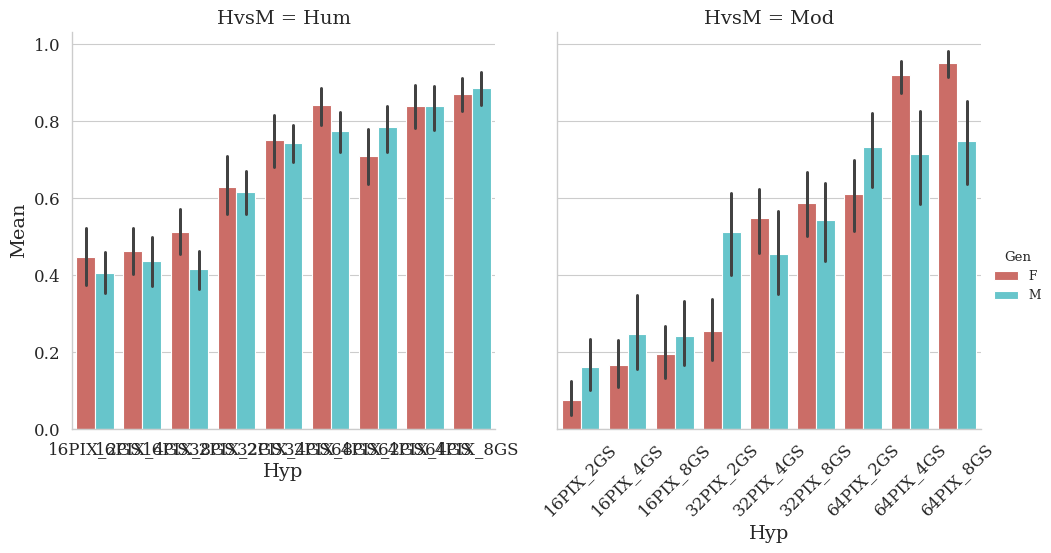

In [171]:
# Is there a gender effect?

order = ['16PIX_2GS', '16PIX_4GS', '16PIX_8GS',
         '32PIX_2GS', '32PIX_4GS', '32PIX_8GS',
         '64PIX_2GS', '64PIX_4GS', '64PIX_8GS']
hue_order = ['F', 'M']
sns.catplot(x='Hyp', y='Mean', col='HvsM', hue='Gen', data=mer_df,
            palette=sns.color_palette("hls", len(hue_order)),
            order=order, hue_order=hue_order,
            kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Facial Recognition Accuracy')
plt.show()

In [172]:
# Draw accuracy values per set order (with hues)
hue_order = ['16PIX_2GS_03', '16PIX_2GS_02', '16PIX_2GS_01',
             '16PIX_4GS_03', '16PIX_4GS_02', '16PIX_4GS_01',
             '16PIX_8GS_03', '16PIX_8GS_02', '16PIX_8GS_01',
             '32PIX_2GS_03', '32PIX_2GS_02', '32PIX_2GS_01',
             '32PIX_4GS_03', '32PIX_4GS_02', '32PIX_4GS_01',
             '32PIX_8GS_03', '32PIX_8GS_02', '32PIX_8GS_01',
             '64PIX_2GS_03', '64PIX_2GS_02', '64PIX_2GS_01',
             '64PIX_4GS_03', '64PIX_4GS_02', '64PIX_4GS_01',
             '64PIX_8GS_03', '64PIX_8GS_02', '64PIX_8GS_01']

plt.figure(figsize=(30, 6.5))
sns.boxplot(x='Set', y='Mean', hue='ImpPar', data=processed_human_df_T, palette=sns.color_palette("hls", 27),
            hue_order=hue_order)
plt.xlabel('Set order')
plt.ylabel('Facial recognition accuracy')
plt.title('Accuracy change over the human experiment', y=1)
plt.legend(bbox_to_anchor=(1, 1.02))
plt.show()

ValueError: Could not interpret input 'Mean'

<Figure size 3000x650 with 0 Axes>